In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\n    "username": "anvishah11",\n    "key": "KGAT_001cf93bc34f3afa9dfb93e3d9f7bf33"\n}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!cat /root/.kaggle/kaggle.json

{
    "username": "anvishah11",
    "key": "KGAT_001cf93bc34f3afa9dfb93e3d9f7bf33"
}

In [5]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [00:50<00:00, 46.8MB/s]
100% 3.75G/3.75G [00:50<00:00, 79.2MB/s]


In [6]:
!mkdir -p data
!unzip -q 140k-real-and-fake-faces.zip -d data
!ls data

real_vs_fake  test.csv	train.csv  valid.csv


In [7]:
!ls data/real_vs_fake/real-vs-fake/train

fake  real


In [8]:
data_dir = "data/real_vs_fake/real-vs-fake"

In [9]:
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/valid"
test_dir =f"{data_dir}/test"

Dataset visualisation

In [10]:
import os

data_dir = "data/real_vs_fake/real-vs-fake"

for split in ["train", "valid", "test"]:
    split_path = os.path.join(data_dir, split)
    print(f"\n{split.upper()}")
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        print(f"  {cls}: {len(os.listdir(cls_path))} images")


TRAIN
  fake: 50000 images
  real: 50000 images

VALID
  fake: 10000 images
  real: 10000 images

TEST
  fake: 10000 images
  real: 10000 images


In [11]:
from PIL import Image

sample_path = os.path.join(data_dir, "train", "fake")
sample_img = os.listdir(sample_path)[0]

img = Image.open(os.path.join(sample_path, sample_img))
print("Image size:", img.size)
print("Image mode:", img.mode)

Image size: (256, 256)
Image mode: RGB


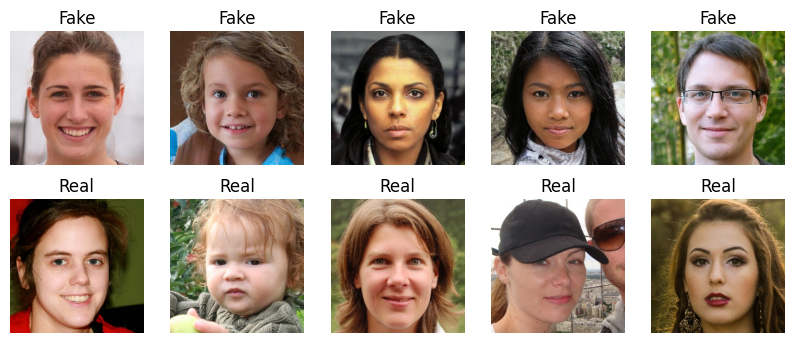

In [12]:
import matplotlib.pyplot as plt
import random

fake_dir = os.path.join(data_dir, "train", "fake")
real_dir = os.path.join(data_dir, "train", "real")

fake_imgs = random.sample(os.listdir(fake_dir), 5)
real_imgs = random.sample(os.listdir(real_dir), 5)

plt.figure(figsize=(10,4))

for i, img_name in enumerate(fake_imgs):
    img = Image.open(os.path.join(fake_dir, img_name))
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title("Fake")
    plt.axis("off")

for i, img_name in enumerate(real_imgs):
    img = Image.open(os.path.join(real_dir, img_name))
    plt.subplot(2,5,i+6)
    plt.imshow(img)
    plt.title("Real")
    plt.axis("off")

plt.show()

In [13]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

In [14]:
train_dataset = ImageFolder(
    root=train_dir,
    transform=train_transforms
)

val_dataset = ImageFolder(
    root=val_dir,
    transform=val_transforms
)

test_dataset = ImageFolder(
    root=test_dir,
    transform=val_transforms
)

In [15]:
print(train_dataset.classes)
print(train_dataset.class_to_idx)

['fake', 'real']
{'fake': 0, 'real': 1}


In [16]:
BATCH_SIZE = 32
NUM_WORKERS = 2  # Colab-safe

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

In [17]:
images, labels = next(iter(train_loader))

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Labels:", labels[:10])

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 1])


In [18]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, 1)
)
for param in model.features.parameters():
    param.requires_grad = False
model = model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30.8M/30.8M [00:00<00:00, 220MB/s]


In [ ]:
model.eval()

dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy_input)

print(output.shape)

torch.Size([1, 1])


In [19]:
for name, param in model.named_parameters():
    if "denseblock4" in name:
        param.requires_grad = True
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

In [20]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([{
"params":model.classifier.parameters(),"lr": 1e-4},
{"params": model.features.denseblock4.parameters(),"lr": 1e-5 }
])

In [ ]:
trainable = sum(p.requires_grad for p in model.parameters())
total = sum(1 for _ in model.parameters())

print(f"Trainable params: {trainable}/{total}")

Trainable params: 104/368


In [ ]:
print(next(iter(train_loader))[1][:10])

tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 1])


In [ ]:
from tqdm import tqdm
import os
# =========================
# TRAINING LOOP (with tqdm)
# =========================
EPOCHS = 5
best_val_acc = 0.0

SAVE_DIR ="/content/models"
os.makedirs(SAVE_DIR, exist_ok=True)
BEST_MODEL_PATH = "/content/models/best_densenet121_unfreeze_lastblock.pth"


for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")
    print("-" * 30)

    # -------- TRAIN --------
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        outputs = model(images).squeeze()      # (B)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        # accuracy
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = correct / total

    # -------- LOGGING --------
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # -------- SAVE BEST MODEL --------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"✅ Best model saved! Val Acc improved to {best_val_acc:.4f}")

print("\nTraining complete.")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Model saved at: {BEST_MODEL_PATH}")



Epoch [1/5]
------------------------------


Validation: 100%|██████████| 625/625 [01:15<00:00,  8.29it/s]


Train Loss: 0.2448 | Train Acc: 0.8963
Val   Loss: 0.1370 | Val   Acc: 0.9462
✅ Best model saved! Val Acc improved to 0.9462

Epoch [2/5]
------------------------------


Validation: 100%|██████████| 625/625 [01:14<00:00,  8.38it/s]


Train Loss: 0.1281 | Train Acc: 0.9501
Val   Loss: 0.0932 | Val   Acc: 0.9651
✅ Best model saved! Val Acc improved to 0.9651

Epoch [3/5]
------------------------------


Validation: 100%|██████████| 625/625 [01:15<00:00,  8.33it/s]


Train Loss: 0.0901 | Train Acc: 0.9657
Val   Loss: 0.0770 | Val   Acc: 0.9708
✅ Best model saved! Val Acc improved to 0.9708

Epoch [4/5]
------------------------------


Validation: 100%|██████████| 625/625 [01:14<00:00,  8.37it/s]


Train Loss: 0.0685 | Train Acc: 0.9738
Val   Loss: 0.0631 | Val   Acc: 0.9758
✅ Best model saved! Val Acc improved to 0.9758

Epoch [5/5]
------------------------------


Validation: 100%|██████████| 625/625 [01:14<00:00,  8.37it/s]


Train Loss: 0.0533 | Train Acc: 0.9797
Val   Loss: 0.0577 | Val   Acc: 0.9795
✅ Best model saved! Val Acc improved to 0.9795

Training complete.
Best Validation Accuracy: 0.9795
Model saved at: /content/models/best_densenet121_unfreeze_lastblock.pth


In [ ]:
from google.colab import files
files.download(BEST_MODEL_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
from google.colab import files
uploaded = files.upload()

Saving best_densenet121_unfreeze_lastblock.pth to best_densenet121_unfreeze_lastblock.pth


In [25]:
!ls /content

140k-real-and-fake-faces.zip		 data	      sample_data
best_densenet121_unfreeze_lastblock.pth  kaggle.json


In [27]:
MODEL_PATH = "/content/best_densenet121_unfreeze_lastblock.pth"

state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)

model.eval()
print("✅ Model loaded successfully")


✅ Model loaded successfully


In [28]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc * 100:.2f}%")


🔥 Test Accuracy: 97.91%
